In [6]:
#first import dependencies, mainly jax and numpyro
import time
from tqdm import tqdm

#we change the config to use 
from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import numpy as np
import arviz as az

from jax import vmap
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import (
    MCMC,
    NUTS,
    init_to_feasible,
    init_to_median,
    init_to_sample,
    init_to_uniform,
    init_to_value,
)
import pandas as pd
#read the data, please change to your data directory
data = pd.read_pickle('/home/dkn16/data.pkl')
FGnopol = data.beam.foregrounds.all_nopol
FGpol = data.beam.foregrounds.pleak
HI = data.beam.HI
noise = data.beam.noise
freqs = data.freqs

superpixel = 16

In [2]:
# read and resize our data
def get_data(dim,pol=False,x0=0,y0=0,freqs = 285,superpixel = 1,selected = None):
    #dim,freqs: the datasize is (dim,dim,freqs)
    #pol(bool): if True, include the polarization leakage data
    #x0,y0: starting coordinates. e.g. pixels within x0:x0+dim will be included in the data.
    #superpixel: if larger than one, reshape the data to be (x_withinsp,y_withinsp,x_sp,y_sp,freq). In this case, data[0][0] is all pixels within superpixel (0,0)
    #selected: indexes to select several channels.
    
    #foreground
    if pol:
        sky = jnp.array(FGnopol+FGpol)[x0:x0+dim,y0:y0+dim,0:freqs].astype(jnp.float64)
    else:
        sky = jnp.array(FGnopol)[x0:x0+dim,y0:y0+dim,0:freqs].astype(jnp.float64)
    
    #HI signal
    cosmos = jnp.array(HI+noise)[x0:x0+dim,y0:y0+dim,0:freqs].astype(jnp.float64)
    
    #substract mean to 
    sky = sky - jnp.mean(sky,axis=(0,1))
    cosmos = cosmos - jnp.mean(cosmos,axis=(0,1))
    
    sky=sky.reshape((dim*dim,freqs))/1000
    cosmos=cosmos.reshape((dim*dim,freqs))/1000
    
    X = jnp.linspace(0., 1., sky.shape[1]).astype(jnp.float64)
    
    Y = sky+cosmos


    if superpixel >1:
        Y = Y.reshape((dim,dim,freqs))
        Y = Y.reshape((int(dim/superpixel),superpixel,int(dim/superpixel),superpixel,freqs)).transpose((0,2,1,3,4))
        Y = Y.reshape((int(int(dim/superpixel)**2),-1,freqs)).transpose((1,0,2))

    
    if selected is not None:
        X = X[selected]
        Y = Y[:,:,selected]

    return X, Y

# if ourdata is in super-pixel structure, i.e. (x_sp,y_sp,x_withinsp,y_withinsp,freq), use this function to turn it back to normal shape
def reverse_data(data,superpixel=1):
    #data = data.transpose((1,0,2))
    dim2 = data.shape[0]*data.shape[1]
    dim = int(np.sqrt(dim2))
    freqs = data.shape[-1]
    if superpixel>1:
        data = data.reshape((int(dim/superpixel),int(dim/superpixel),superpixel,superpixel,freqs)).transpose((0,2,1,3,4))
        data = data.reshape((-1,freqs))
    return data

#reverse a batch of data in super-pixel shape.
def reverse_data_batch(data,superpixel=1):
    #data = data.transpose((1,0,2))
    dim2 = data.shape[1]*data.shape[2]
    batch = data.shape[0]
    dim = int(np.sqrt(dim2))
    freqs = data.shape[-1]
    if superpixel>1:
        data = data.reshape((batch,int(dim/superpixel),int(dim/superpixel),superpixel,superpixel,freqs)).transpose((0,1,3,2,4,5))
        data = data.reshape((batch,-1,freqs))
    return data

In [8]:
# we still need to put these functions here as we will unpickle our stored mcmc object

# RBF kernel for fg, exponential kernel for HI, and a diagonal noise kernel
def kernel(X, Z, var, length,var_HI,length_HI, noise, jitter=1.0e-16,is_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    deltaHI = jnp.abs((X[:, None] - Z) / length_HI)
    
    k_fg = var * jnp.exp(-0.5 * deltaXsq)
    k_HI = 1.0e-9*var_HI * jnp.exp(-0.5 * deltaHI)
    #k = var * jnp.exp(-0.5 * deltaXsq)
    if is_noise:
        k_HI += (noise*noise*1.0e-14 + jitter) * jnp.eye(X.shape[0])
        k_fg += k_HI
    return k_fg

# RBF kernel for fg, another RBF kernel for pol, exponential kernel for HI, and a diagonal noise kernel
def kernel_pol(X, Z, var, length,var_pol,length_pol,var_HI,length_HI, noise, jitter=1.0e-16,is_noise=True):
    deltaXsq = jnp.power((X[:, None] - Z) / length, 2.0)
    deltapol = jnp.power((X[:, None] - Z) / length_pol, 2.0)
    deltaHI = jnp.abs((X[:, None] - Z) *100/ length_HI)
    
    k_fg = 1.0e-2*var * jnp.exp(-0.5 * deltaXsq)
    k_pol = 1.0e-6*var_pol * jnp.exp(-0.5 * deltapol)
    k_HI = 1.0e-9*var_HI * jnp.exp(-0.5 * deltaHI)
    #k = var * jnp.exp(-0.5 * deltaXsq)
    if is_noise:
        k_HI += (noise*noise*1.0e-14 + jitter) * jnp.eye(X.shape[0])
        k_fg += k_HI
    return k_fg + k_pol


def model(X, Y):
    #set weakly-informative log-normal priors on all kernel hyperparameters
    var_fg_std = numpyro.sample("varfg_std", dist.LogNormal(0,4))
    
    length_fg_alpha = numpyro.sample("length_fg_alpha",dist.LogNormal(1,4))
    length_fg_beta = numpyro.sample("length_fg_beta",dist.LogNormal(0,4))
    
    noise = numpyro.sample("kernel_noise", dist.HalfNormal(10))
    
    
    var_pol_std = numpyro.sample("varpol_std", dist.LogNormal(0,4))
    
    length_pol_mean = numpyro.sample("length_pol_mean",dist.LogNormal(1,4))
    length_pol_std = numpyro.sample("length_pol_std",dist.LogNormal(0,4))
    
    var_HI = numpyro.sample("kernel_varHI", dist.HalfNormal(1))
    length_HI = numpyro.sample("kernel_lengthHI",dist.HalfNormal(2))
    var_fg = numpyro.sample("kernel_var", dist.HalfNormal(jnp.ones(Y.shape[1])*var_fg_std))
    length_fg = numpyro.sample("kernel_length", dist.InverseGamma(jnp.ones(Y.shape[1])*length_fg_alpha,jnp.ones(Y.shape[1])*length_fg_beta))
    var_pol = numpyro.sample("kernel_varpol", dist.HalfNormal(jnp.ones(Y.shape[1])*var_pol_std))
    length_pol = numpyro.sample("kernel_lengthpol", dist.InverseGamma(jnp.ones(Y.shape[1])*length_pol_mean,jnp.ones(Y.shape[1])*length_pol_std))

    # compute kernel
    X=jnp.repeat(jnp.array([X]),Y.shape[1],axis=0)
    
    vmap_args = (
        X,X,var_fg,length_fg,var_pol,length_pol
    )
    
    #using vmap to calculate k in batch
    k = vmap(
        lambda X,  Z,var_fg,length_fg,var_pol,length_pol: kernel_pol(
            X, Z,var_fg,length_fg,var_pol,length_pol,var_HI,length_HI,noise
        )
    )(*vmap_args)
    
    #this is for calculating the likelihood
    numpyro.sample(
        "Y",
        dist.MultivariateNormal(loc=jnp.zeros((Y.shape[1],Y.shape[2])), covariance_matrix=k),
        obs=Y,
    )


# helper function for doing hmc inference
def run_inference(model,init_strategy, rng_key, X, Y):
    start = time.time()
    # demonstrate how to use different HMC initialization strategies
    if init_strategy == "value":
        init_strategy = init_to_value(
            values={"kernel_var": jnp.ones(Y.shape[1]), "kernel_noise": 1, "kernel_length": jnp.ones(Y.shape[1]), "kernel_varpol": jnp.ones(Y.shape[1]), "kernel_lengthpol": 0.5*jnp.ones(Y.shape[1]),"kernel_varHI": 1.0, "kernel_lengthHI": 1.0,"varfg_std":1.0,"length_fg_alpha":2.,"length_fg_beta":1.,"varpol_std":1.,"length_pol_mean":5.,"length_pol_std":1.}
        )
    elif init_strategy == "median":
        init_strategy = init_to_median(num_samples=10)
    elif init_strategy == "feasible":
        init_strategy = init_to_feasible()
    elif init_strategy == "sample":
        init_strategy = init_to_sample()
    elif init_strategy == "uniform":
        init_strategy = init_to_uniform(radius=1)

    #pass our model to numpyro built-in NUTS and MCMC function
    kernel = NUTS(
        model,
        init_strategy=init_strategy,
        target_accept_prob=0.8,
        max_tree_depth=8)
    mcmc = MCMC(
        kernel,
        num_warmup=1000,
        num_samples=2000,
        num_chains=1,
        thinning=1,
        progress_bar= True,
    )

    #mcmc.run() would do everything
    mcmc.run(rng_key, X, Y)
    mcmc.print_summary()

    print("\nMCMC elapsed time:", time.time() - start)

    #here we use arviz package to calculate the cross validation score, which is equivalent to Bayesian evidence.
    idata = az.from_numpyro(mcmc)
    loo_orig = az.loo(idata, pointwise=True)
    print(loo_orig)
    return mcmc.get_samples(),mcmc


# do GP prediction for a given set of hyperparameters. this makes use of the well-known
# formula for gaussian process predictions
def predict(X, Y, X_test, var, length,var_pol, length_pol,var_HI, length_HI, noise):
    # compute kernels  K_fg
    k_pp = kernel_pol(X_test, X_test, var, length,var_pol, length_pol,var_HI, length_HI, noise,is_noise=False)

    #K_fg+k_HI
    k_XX = kernel_pol(X, X, var, length,var_pol, length_pol,var_HI, length_HI, noise,is_noise=True)

    #(K_fg+K_HI)^-1
    K_xx_inv = jnp.linalg.inv(k_XX)
    
    #E(d_fg|d_obs)
    mean = jnp.matmul(k_pp, jnp.matmul(K_xx_inv, Y.T)).T
    return mean




def main():
    
    X, Y = get_data(pol=True,dim=256,x0=0,y0=0,freqs=256,superpixel=superpixel)

    # do inference
    rng_key, rng_key_predict = random.split(random.PRNGKey(42))
    samples = run_inference(model, "median", rng_key, X, Y)
    return samples

    
def predict_fg(samples,thinning=50,selected=None):
    # we thing the chain to reduce the computational cost
    X, Y = get_data(pol=True,dim=256,x0=0,y0=0,freqs=256,superpixel=superpixel,selected=selected)
    
    # do prediction
    means = []
    for i in tqdm(range(Y.shape[1]), desc='Processing', unit='iter'):
        #do prediction for each super pixel
        vmap_args = (
            samples["kernel_var"][::thinning,i],
            samples["kernel_length"][::thinning,i],
            samples["kernel_varpol"][::thinning,i],
            samples["kernel_lengthpol"][::thinning,i],
            samples["kernel_varHI"][::thinning],
            samples["kernel_lengthHI"][::thinning],
            samples["kernel_noise"][::thinning]
            #samples["kernel_noise"][-1:-1*batch-1:-1],
        )
        
        means.append(vmap(
            lambda  var, length,var_pol, length_pol,var_HI, length_HI,noise: predict(
                 X, Y[:,i,:], X, var, length,var_pol, length_pol,var_HI, length_HI, noise
            )
        )(*vmap_args))

    mean_prediction = np.mean(means, axis=1)
    percentiles = np.percentile(means, [5.0, 95.0], axis=1)
    
    return X,mean_prediction,percentiles,samples,means

In [13]:
#a trial run for 20 iters to check eveything's alright
numpyro.set_platform('gpu')
numpyro.set_host_device_count(1)
samples = main()

sample: 100%|█| 20/20 [00:15<00:00,  1.29it/s, 6 steps of size 6.18e-04. acc. pr



                           mean       std    median      5.0%     95.0%     n_eff     r_hat
     kernel_length[0]      0.34      0.00      0.34      0.34      0.34      2.41      3.77
     kernel_length[1]      0.42      0.00      0.42      0.42      0.42      2.50      2.87
     kernel_length[2]      0.41      0.00      0.41      0.41      0.41      2.85      2.04
     kernel_length[3]      0.34      0.00      0.34      0.34      0.34      2.64      2.21
     kernel_length[4]      0.41      0.00      0.41      0.41      0.41      2.41      3.49
     kernel_length[5]      0.48      0.00      0.48      0.48      0.48      2.43      4.19
     kernel_length[6]      0.41      0.00      0.41      0.41      0.41      2.50      2.54
     kernel_length[7]      0.44      0.00      0.44      0.44      0.44      2.81      2.05
     kernel_length[8]      0.39      0.00      0.39      0.39      0.39      2.50      2.57
     kernel_length[9]      0.33      0.00      0.33      0.33      0.33      2.

In [4]:
#selected = np.concatenate([np.arange(64),np.arange(32)+128,np.arange(32)+224])
selected = None
import pickle
mcmc_file = open("samples_hgp_pol_init.bin", "rb")
mcmc = pickle.load(mcmc_file)
mcmc_file.close()
samples = mcmc.get_samples()

In [9]:
X,mean_prediction,percentiles,samples,means = predict_fg(samples,selected=selected)

Processing: 100%|███████████████████████████| 256/256 [00:14<00:00, 17.46iter/s]


In [10]:
# reverse to the normal shape
mean_rev = reverse_data(mean_prediction,superpixel=superpixel)
print(mean_rev.shape)
perc_rev = [reverse_data(percentiles[0],superpixel=superpixel),reverse_data(percentiles[1],superpixel=superpixel)]

(65536, 256)


In [11]:
means_rev = reverse_data_batch(np.array(means).transpose((1,0,2,3)),superpixel=superpixel)

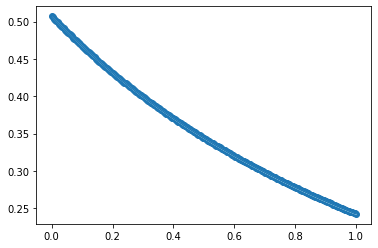

In [13]:
#plot obs data and our separated foreground
X, Y = get_data(pol=True,dim=256,x0=0,y0=0,freqs=256,superpixel=1,selected=selected)
plt.scatter(X,Y[0])
plt.plot(X,mean_rev[0])
plt.fill_between(X, perc_rev[0][0,:], perc_rev[1][0,:], color="lightblue")
#np.save('/scratch/dkn16/result_np_pol.npy',(np.array(Y)-means_rev).reshape((-1,256,256,Y.shape[-1])))

In [17]:
#collect the true HI data
x0 = 0
y0 = 0
dim = 256
freqs = 256
#selected = np.concatenate([np.arange(64),np.arange(32)+128,np.arange(32)+224])

cosmos = (HI+noise)[x0:x0+dim,y0:y0+dim,0:freqs]
#cosmos = cosmos[:,:,selected]
cosmos = cosmos - jnp.mean(cosmos,axis=(0,1))
cosmos = cosmos.reshape(dim*dim,-1)

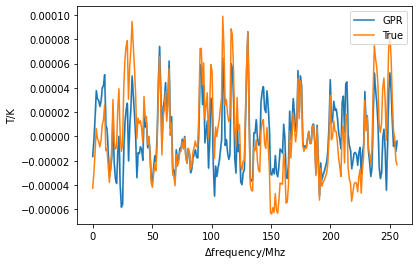

In [19]:
#plot recovered HI at some pixel
i=245
plt.plot(X*freqs,Y[i]-mean_rev[i])

plt.plot(X*freqs,cosmos[i]/1000)
plt.fill_between(X*freqs,Y[i]-perc_rev[0][ i,:], Y[i]-perc_rev[1][ i,:], color="lightblue")
plt.xlabel(r'$\Delta$frequency/Mhz')
plt.ylabel(r'T/K')
plt.legend(['GPR','True'])

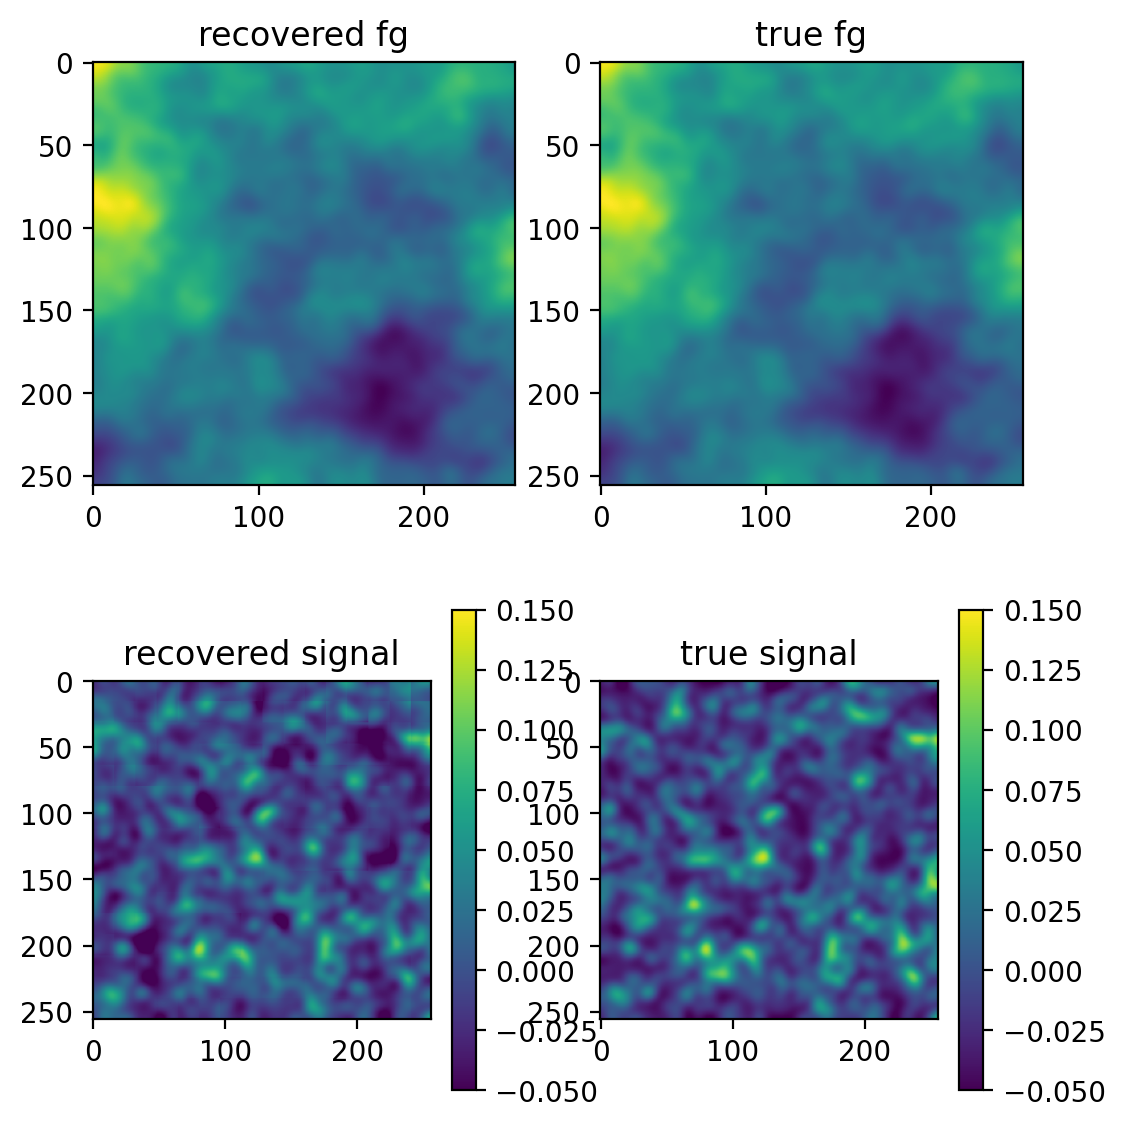

In [20]:
#plot images at i-th frequency slice
i=8
plt.figure(figsize=(6,7),dpi=200)
plt.subplot(2,2,1)
plt.imshow(mean_rev[:,i].reshape(dim,dim))
plt.title('recovered fg')
plt.subplot(2,2,2)
plt.imshow(Y[:,i].reshape(dim,dim))
plt.title('true fg')
plt.subplot(2,2,3)
plt.imshow((Y[:,i]-mean_rev[:,i]).reshape(dim,dim)*1000,vmax=0.15,vmin=-0.05)
plt.title('recovered signal')
plt.colorbar()
plt.subplot(2,2,4)
plt.imshow(cosmos[:,i].reshape(dim,dim),vmax=0.15,vmin=-0.05)
plt.title('true signal')
plt.colorbar()

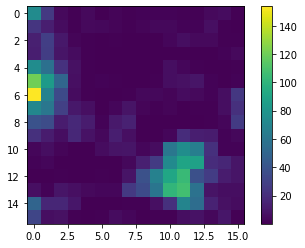

In [21]:
#plot our parameter
plt.imshow(samples['kernel_var'][500,:].reshape(16,16))
plt.colorbar()